<a href="https://colab.research.google.com/github/manyamule/WCEHackathon2025_Introspectors/blob/main/One_class_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn


In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Create directories for saving outputs
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("Environment set up complete!")


Environment set up complete!


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data from CSV with flexible date parsing
def load_data(csv_path):
    print(f"Loading data from: {csv_path}")

    # First, try to determine if the file is tab-separated or comma-separated
    with open(csv_path, 'r') as f:
        first_line = f.readline().strip()
        if '\t' in first_line:
            print("Detected tab-separated file")
            df = pd.read_csv(csv_path, sep='\t')
        else:
            print("Assuming comma-separated file")
            df = pd.read_csv(csv_path)

    print(f"Raw data shape: {df.shape}")
    print("Column names:", df.columns.tolist())
    print("\nFirst 3 rows of raw data:")
    print(df.head(3))

    # Convert datetime column to datetime type and set as index
    if 'dt_time' in df.columns:
        # Try to parse dates with pandas' flexible parser
        print("\nConverting dates to datetime format...")
        df['dt_time'] = pd.to_datetime(df['dt_time'], infer_datetime_format=True)
        df.set_index('dt_time', inplace=True)

    print(f"\nProcessed data shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values per column:")
        print(missing[missing > 0])

    return df

# Load air quality data
data = load_data('/content/drive/MyDrive/WCE/air_quality_data.csv')

# Display first few rows of processed data
print("\nFirst 5 rows of processed data:")
data.head()

Mounted at /content/drive
Loading data from: /content/drive/MyDrive/WCE/air_quality_data.csv
Assuming comma-separated file
Raw data shape: (3356255, 4)
Column names: ['dt_time', 'pm2.5cnc', 'pm10cnc', 'deviceid']

First 3 rows of raw data:
               dt_time  pm2.5cnc  pm10cnc  deviceid
0  2023-12-29 00:00:00    170.58   260.87  site_104
1  2023-12-29 00:15:00    164.56   279.53  site_104
2  2023-12-29 00:30:00    186.15   296.75  site_104

Converting dates to datetime format...

Processed data shape: (3356255, 3)
Date range: 2023-12-29 00:00:00 to 2024-12-31 00:00:00

Missing values per column:
pm2.5cnc    568730
pm10cnc     577798
dtype: int64

First 5 rows of processed data:


,pm2.5cnc,pm10cnc,deviceid
dt_time,,,
2023-12-29 00:00:00,170.58,260.87,site_104
2023-12-29 00:15:00,164.56,279.53,site_104
2023-12-29 00:30:00,186.15,296.75,site_104
2023-12-29 00:45:00,205.22,318.59,site_104
2023-12-29 01:00:00,211.11,334.24,site_104


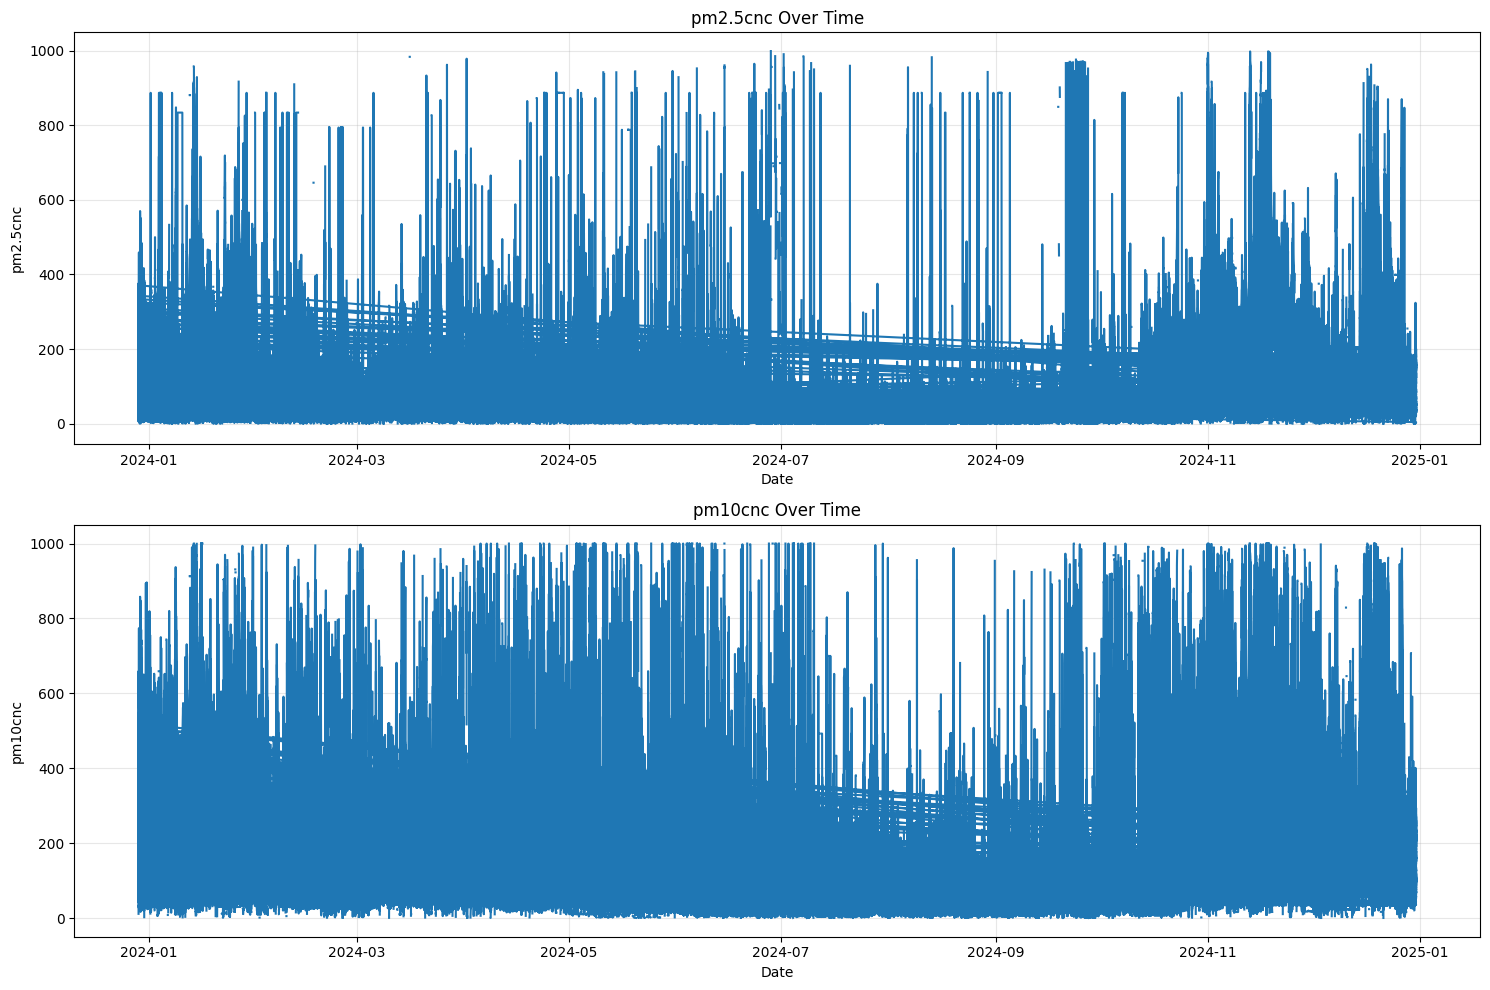

Data visualization complete!


In [7]:
# Visualize the data to understand its characteristics
def plot_air_quality_data(df, parameters):
    """Plot the air quality parameters over time."""
    plt.figure(figsize=(15, 5 * len(parameters)))

    for i, param in enumerate(parameters):
        if param in df.columns:
            plt.subplot(len(parameters), 1, i+1)
            plt.plot(df.index, df[param])
            plt.title(f'{param} Over Time')
            plt.xlabel('Date')
            plt.ylabel(param)
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/air_quality_overview.png')
    plt.show()

# Plot PM2.5 and PM10 concentrations
params = ['pm2.5cnc', 'pm10cnc']
plot_air_quality_data(data, params)

print("Data visualization complete!")

In [8]:
def preprocess_data(df, params=None, resample=True, resample_freq='1h', train_ratio=0.8):
    """
    Preprocess the air quality data:
    - Select specific parameters
    - Handle missing values
    - Resample to regular intervals
    - Split into train/test sets
    """
    print("Starting data preprocessing...")

    # Select parameters if provided
    if params and all(param in df.columns for param in params):
        print(f"Selecting parameters: {params}")
        df = df[params]

    # Handle missing values
    if df.isnull().sum().sum() > 0:
        print(f"Handling {df.isnull().sum().sum()} missing values")
        df.ffill(inplace=True)  # Forward fill
        df.bfill(inplace=True)  # Backward fill

    # Resample data if needed
    if resample:
        print(f"Resampling data to {resample_freq}")
        df = df.resample(resample_freq).mean()
        df.ffill(inplace=True)
        df.bfill(inplace=True)

    # Time-based train-test split
    print(f"Performing time-based train-test split with ratio {train_ratio}")
    split_idx = int(len(df) * train_ratio)
    train_data = df.iloc[:split_idx]
    test_data = df.iloc[split_idx:]

    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    return df, train_data, test_data

# Preprocess the data
preprocessed_data, train_data, test_data = preprocess_data(
    data,
    params=params,
    resample=True,
    resample_freq='1h',
    train_ratio=0.8
)

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

print("Data preprocessing complete!")
print("\nPreprocessed data (hourly averages):")
preprocessed_data.head()

Starting data preprocessing...
Selecting parameters: ['pm2.5cnc', 'pm10cnc']
Handling 1146528 missing values
Resampling data to 1h
Performing time-based train-test split with ratio 0.8
Train data shape: (7066, 2), Test data shape: (1767, 2)
Data preprocessing complete!

Preprocessed data (hourly averages):


,pm2.5cnc,pm10cnc
dt_time,,
2023-12-29 00:00:00,127.568579,217.236579
2023-12-29 01:00:00,127.819000,220.494658
2023-12-29 02:00:00,124.464000,213.474184
2023-12-29 03:00:00,120.631447,208.380921
2023-12-29 04:00:00,117.210395,200.544342


In [9]:
def create_one_class_svm(kernel='rbf', nu=0.05, gamma='scale'):
    """
    Create a One-Class SVM model for anomaly detection.

    Args:
        kernel: Kernel type ('rbf', 'linear', 'poly', 'sigmoid')
        nu: An upper bound on the fraction of training errors (typically 0.01-0.1)
        gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'

    Returns:
        Initialized One-Class SVM model
    """
    model = OneClassSVM(
        kernel=kernel,
        nu=nu,
        gamma=gamma
    )
    return model

# Create and train the One-Class SVM model
print("Creating and training One-Class SVM model...")
print("This may take a moment...")

# Create the model with default parameters
one_class_svm = create_one_class_svm(kernel='rbf', nu=0.05, gamma='scale')

# Train the model on the scaled training data
one_class_svm.fit(scaled_train)

# Save the model and scaler
import joblib
joblib.dump(one_class_svm, 'models/one_class_svm.joblib')
joblib.dump(scaler, 'models/one_class_svm_scaler.joblib')

print("Model saved to 'models/one_class_svm.joblib'")
print("Scaler saved to 'models/one_class_svm_scaler.joblib'")

Creating and training One-Class SVM model...
This may take a moment...
Model saved to 'models/one_class_svm.joblib'
Scaler saved to 'models/one_class_svm_scaler.joblib'


In [10]:
# Detect anomalies using the trained One-Class SVM model
def detect_anomalies_svm(model, data):
    """
    Detect anomalies using a fitted One-Class SVM model.

    Args:
        model: Trained One-Class SVM model
        data: Scaled data to detect anomalies in

    Returns:
        anomaly_scores: Raw anomaly scores
        anomalies: Boolean array of anomalies
    """
    # Get decision scores
    # Note: Lower (more negative) values are more anomalous
    anomaly_scores = -model.decision_function(data)  # Negate so higher = more anomalous

    # Get binary predictions (1: inlier, -1: outlier)
    raw_predictions = model.predict(data)

    # Convert to boolean array (True for anomalies)
    anomalies = raw_predictions == -1

    return anomaly_scores, anomalies

# Detect anomalies in the test set
print("Detecting anomalies in the test data...")
test_scores, test_anomalies = detect_anomalies_svm(one_class_svm, scaled_test)

# Create a DataFrame with the results
results = pd.DataFrame(index=test_data.index)
results['anomaly_score'] = test_scores
results['anomaly'] = test_anomalies

# Add original data for reference
for col in test_data.columns:
    results[col] = test_data[col].values

# Calculate anomaly statistics
anomaly_count = results['anomaly'].sum()
total_points = len(results)
anomaly_percent = (anomaly_count / total_points) * 100

print(f"Detected {anomaly_count} anomalies out of {total_points} points ({anomaly_percent:.2f}%)")

# Save results to CSV
results.to_csv('reports/one_class_svm_anomalies.csv')
print("Results saved to 'reports/one_class_svm_anomalies.csv'")

# Display results
print("\nDetection results:")
results

Detecting anomalies in the test data...
Detected 457 anomalies out of 1767 points (25.86%)
Results saved to 'reports/one_class_svm_anomalies.csv'

Detection results:


,anomaly_score,anomaly,pm2.5cnc,pm10cnc
dt_time,,,,
2024-10-18 10:00:00,-8.086485,False,70.053553,168.432684
2024-10-18 11:00:00,-10.068553,False,61.615579,154.276921
2024-10-18 12:00:00,-9.229984,False,48.537105,129.464132
2024-10-18 13:00:00,-7.289121,False,42.861289,114.952000
2024-10-18 14:00:00,-6.281445,False,39.351105,107.666289
...,...,...,...,...
2024-12-30 20:00:00,-4.931473,False,71.093237,135.954053
2024-12-30 21:00:00,-4.772226,False,71.267763,135.726921
2024-12-30 22:00:00,-4.266903,False,73.687553,138.009342


Generating anomaly plots...


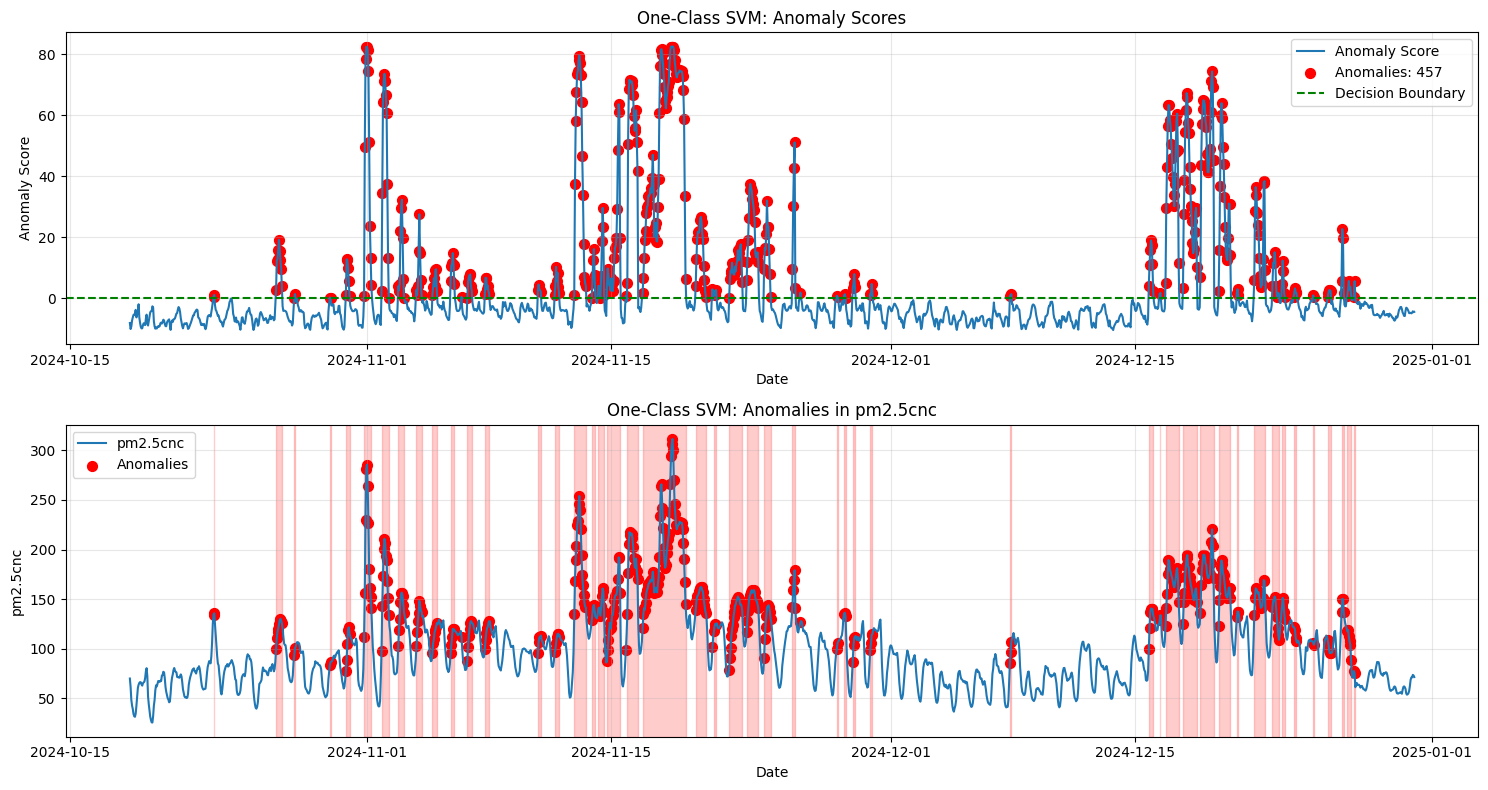

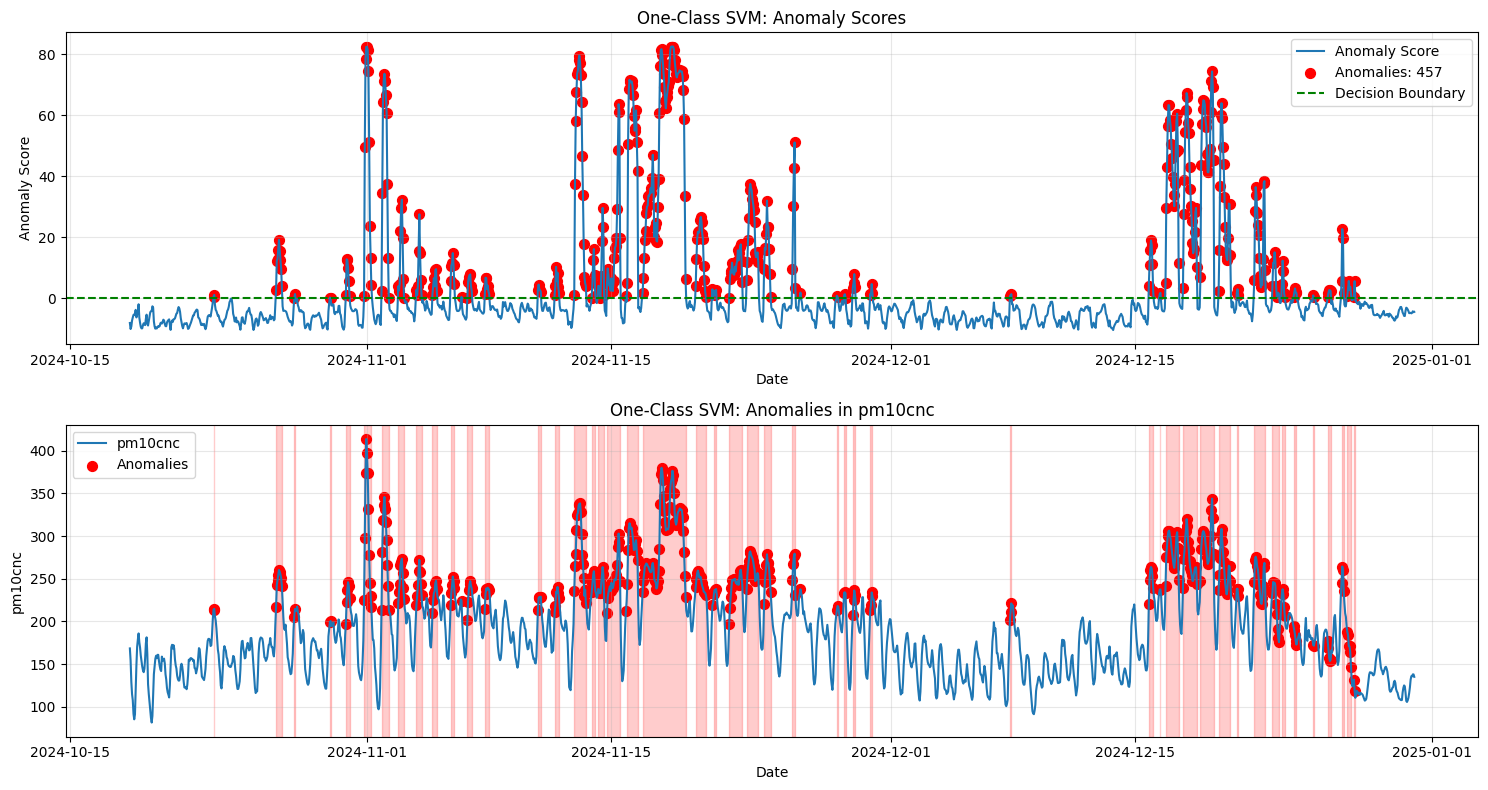

Anomaly visualization complete!


In [11]:
def plot_anomalies(results, parameter, model_name='One-Class SVM'):
    """
    Plot the original time series with anomalies highlighted.

    Args:
        results: DataFrame with anomaly results
        parameter: Parameter to plot
        model_name: Name of the model
    """
    plt.figure(figsize=(15, 8))

    # Plot 1: Anomaly scores
    plt.subplot(2, 1, 1)
    plt.plot(results.index, results['anomaly_score'], label='Anomaly Score')

    # Highlight anomalies in the score plot
    anomalies = results[results['anomaly']]
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies['anomaly_score'],
                    color='red', label=f'Anomalies: {len(anomalies)}', s=50)

    # Add a horizontal line at the threshold (for SVM, this is 0 after negation)
    plt.axhline(y=0, color='green', linestyle='--',
                label='Decision Boundary')

    plt.title(f'{model_name}: Anomaly Scores')
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Original time series with anomalies highlighted
    plt.subplot(2, 1, 2)
    plt.plot(results.index, results[parameter], label=parameter)

    # Highlight anomalies
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[parameter],
                   color='red', label='Anomalies', s=50)

        # Optionally highlight continuous anomaly segments
        if len(anomalies) > 1:
            anomalies['date'] = anomalies.index
            try:
                anomalies['group'] = (anomalies['date'].diff() > pd.Timedelta('1h')).cumsum()

                for group, group_data in anomalies.groupby('group'):
                    if len(group_data) > 1:  # Only highlight if more than one point
                        start = group_data.index.min()
                        end = group_data.index.max()
                        plt.axvspan(start, end, color='red', alpha=0.2)
            except:
                # If there's only one anomaly, we can't calculate differences
                pass

    plt.title(f'{model_name}: Anomalies in {parameter}')
    plt.xlabel('Date')
    plt.ylabel(parameter)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_{parameter}_anomalies.png')
    plt.show()

# Plot anomalies for each parameter
print("Generating anomaly plots...")
for param in params:
    plot_anomalies(results, param)
print("Anomaly visualization complete!")

In [12]:
def compare_models(svm_results, isolation_forest_path='reports/isolation_forest_anomalies.csv'):
    """
    Compare anomalies detected by One-Class SVM with those from Isolation Forest.

    Args:
        svm_results: DataFrame with One-Class SVM results
        isolation_forest_path: Path to saved Isolation Forest results

    Returns:
        DataFrame with comparison results
    """
    print("Comparing One-Class SVM with Isolation Forest...")

    # Check if Isolation Forest results exist
    if not os.path.exists(isolation_forest_path):
        print(f"Isolation Forest results not found at {isolation_forest_path}")
        print("Skipping comparison.")
        return None

    # Load Isolation Forest results
    try:
        if_results = pd.read_csv(isolation_forest_path, index_col=0, parse_dates=True)
        print(f"Loaded Isolation Forest results with {len(if_results)} rows")
    except Exception as e:
        print(f"Error loading Isolation Forest results: {str(e)}")
        print("Skipping comparison.")
        return None

    # Align indices between the two result sets
    common_indices = svm_results.index.intersection(if_results.index)
    if len(common_indices) == 0:
        print("No common time points between SVM and Isolation Forest results")
        print("Skipping comparison.")
        return None

    # Create aligned DataFrames
    svm_aligned = svm_results.loc[common_indices]
    if_aligned = if_results.loc[common_indices]

    # Create comparison DataFrame
    comparison = pd.DataFrame(index=common_indices)
    comparison['svm_anomaly_score'] = svm_aligned['anomaly_score']
    comparison['svm_anomaly'] = svm_aligned['anomaly']
    comparison['if_anomaly_score'] = if_aligned['anomaly_score']
    comparison['if_anomaly'] = if_aligned['anomaly']

    # Add original data columns
    for col in svm_aligned.columns:
        if col not in ['anomaly_score', 'anomaly']:
            comparison[col] = svm_aligned[col]

    # Calculate agreement statistics
    agreement = comparison['svm_anomaly'] == comparison['if_anomaly']
    agreement_percent = agreement.mean() * 100

    both_anomaly = (comparison['svm_anomaly'] & comparison['if_anomaly']).sum()
    only_svm = (comparison['svm_anomaly'] & ~comparison['if_anomaly']).sum()
    only_if = (~comparison['svm_anomaly'] & comparison['if_anomaly']).sum()
    neither = (~comparison['svm_anomaly'] & ~comparison['if_anomaly']).sum()

    print(f"\nModel comparison statistics:")
    print(f"Total points: {len(comparison)}")
    print(f"Agreement between models: {agreement_percent:.2f}%")
    print(f"Both models detect anomaly: {both_anomaly} points")
    print(f"Only SVM detects anomaly: {only_svm} points")
    print(f"Only Isolation Forest detects anomaly: {only_if} points")
    print(f"Neither model detects anomaly: {neither} points")

    # Visualize comparison
    plt.figure(figsize=(15, 10))

    # Plot original time series
    for i, param in enumerate(params):
        plt.subplot(len(params) + 1, 1, i + 1)
        plt.plot(comparison.index, comparison[param], label=param)

        # Mark anomalies from both models
        both = comparison[(comparison['svm_anomaly']) & (comparison['if_anomaly'])]
        only_svm_points = comparison[(comparison['svm_anomaly']) & (~comparison['if_anomaly'])]
        only_if_points = comparison[(~comparison['svm_anomaly']) & (comparison['if_anomaly'])]

        if not both.empty:
            plt.scatter(both.index, both[param], color='red', label='Both Models', s=100, marker='*')

        if not only_svm_points.empty:
            plt.scatter(only_svm_points.index, only_svm_points[param], color='blue', label='Only SVM', s=80, marker='o')

        if not only_if_points.empty:
            plt.scatter(only_if_points.index, only_if_points[param], color='green', label='Only Isolation Forest', s=80, marker='s')

        plt.title(f'Anomalies in {param}: One-Class SVM vs. Isolation Forest')
        plt.xlabel('Date')
        plt.ylabel(param)
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot anomaly scores from both models
    plt.subplot(len(params) + 1, 1, len(params) + 1)
    plt.plot(comparison.index, comparison['svm_anomaly_score'], color='blue', label='SVM Score')
    plt.plot(comparison.index, comparison['if_anomaly_score'], color='green', label='Isolation Forest Score')

    # Highlight anomalies detected by each model
    svm_anomalies = comparison[comparison['svm_anomaly']]
    if_anomalies = comparison[comparison['if_anomaly']]

    if not svm_anomalies.empty:
        plt.scatter(svm_anomalies.index, svm_anomalies['svm_anomaly_score'], color='blue', label='SVM Anomalies', s=80, marker='o')

    if not if_anomalies.empty:
        plt.scatter(if_anomalies.index, if_anomalies['if_anomaly_score'], color='green', label='IF Anomalies', s=80, marker='s')

    plt.title('Anomaly Scores: One-Class SVM vs. Isolation Forest')
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/model_comparison.png')
    plt.show()

    # Save comparison results
    comparison.to_csv('reports/model_comparison.csv')
    print("Comparison saved to 'reports/model_comparison.csv'")

    return comparison

# Compare One-Class SVM with Isolation Forest (if available)
comparison_results = compare_models(results)

Comparing One-Class SVM with Isolation Forest...
Isolation Forest results not found at reports/isolation_forest_anomalies.csv
Skipping comparison.


In [15]:
# SAVE RESULTS TO GOOGLE DRIVE
# Run this cell after your analysis is complete

# Mount Google Drive if not already mounted
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Set up base directory in Drive where results will be saved
base_drive_dir = '/content/drive/MyDrive/WCE/anomaly_detection_results'

# Local directories containing results
local_dirs = {
    'models': 'models',
    'plots': 'plots',
    'reports': 'reports'
}

import os
import shutil
from datetime import datetime

# Create timestamp for the result folder (optional, for versioning)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
result_dir = f"{base_drive_dir}/{timestamp}"

# Create the main directory
os.makedirs(result_dir, exist_ok=True)
print(f"Creating result directory: {result_dir}")

# Copy all files from local directories to Drive
files_copied = 0
for dir_type, local_dir in local_dirs.items():
    drive_subdir = f"{result_dir}/{dir_type}"
    os.makedirs(drive_subdir, exist_ok=True)

    # Check if local directory exists
    if os.path.exists(local_dir):
        # List all files in the directory
        files = os.listdir(local_dir)
        if files:
            print(f"\nCopying {len(files)} files from '{local_dir}/' to '{drive_subdir}/':")

            # Copy each file
            for filename in files:
                local_path = os.path.join(local_dir, filename)
                drive_path = os.path.join(drive_subdir, filename)

                if os.path.isfile(local_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied: {filename}")
                    files_copied += 1
        else:
            print(f"\nNo files found in {local_dir}/")
    else:
        print(f"\nLocal directory '{local_dir}/' not found")

# Also save a copy of the current notebook
try:
    from google.colab import files
    import json

    # Get notebook content
    notebook_content = json.loads('!echo "$(cat /content/drive/MyDrive/Colab\ Notebooks/*.ipynb)"')

    # Save a copy in the results directory
    notebook_path = f"{result_dir}/notebook_backup.ipynb"
    with open(notebook_path, 'w') as f:
        json.dump(notebook_content, f)

    print(f"\nSaved notebook backup to {notebook_path}")
    files_copied += 1
except:
    print("\nCould not save notebook backup")

print(f"\nSaved a total of {files_copied} files to Google Drive at: {result_dir}")
print("DONE!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating result directory: /content/drive/MyDrive/WCE/anomaly_detection_results/20250314_180853

Copying 2 files from 'models/' to '/content/drive/MyDrive/WCE/anomaly_detection_results/20250314_180853/models/':
  - Copied: one_class_svm.joblib
  - Copied: one_class_svm_scaler.joblib

Copying 3 files from 'plots/' to '/content/drive/MyDrive/WCE/anomaly_detection_results/20250314_180853/plots/':
  - Copied: air_quality_overview.png
  - Copied: one-class_svm_pm10cnc_anomalies.png
  - Copied: one-class_svm_pm2.5cnc_anomalies.png

Copying 1 files from 'reports/' to '/content/drive/MyDrive/WCE/anomaly_detection_results/20250314_180853/reports/':
  - Copied: one_class_svm_anomalies.csv

Could not save notebook backup

Saved a total of 6 files to Google Drive at: /content/drive/MyDrive/WCE/anomaly_detection_results/20250314_180853
DONE!


In [16]:
# SAVE ONE-CLASS SVM RESULTS TO GOOGLE DRIVE
# Run this cell after your One-Class SVM analysis is complete

# Mount Google Drive if not already mounted
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Set up directory in Drive where One-Class SVM results will be saved
one_class_svm_dir = '/content/drive/MyDrive/WCE/one_class_svm_results'

# Local directories and files patterns for One-Class SVM
one_class_svm_files = {
    'models': ['one_class_svm.joblib', 'one_class_svm_scaler.joblib', '*svm*.joblib'],
    'plots': ['one_class_svm_*.png', '*svm*.png'],
    'reports': ['one_class_svm_*.csv', 'one_class_svm_*.json', 'one_class_svm_summary.md',
                '*svm*_tuning.csv', 'model_comparison.csv']
}

import os
import shutil
import glob

# Create the main directory
os.makedirs(one_class_svm_dir, exist_ok=True)
print(f"Creating One-Class SVM results directory: {one_class_svm_dir}")

# Copy all One-Class SVM files from local directories to Drive
files_copied = 0

for dir_type, patterns in one_class_svm_files.items():
    # Create subdirectory in Drive
    drive_subdir = f"{one_class_svm_dir}/{dir_type}"
    os.makedirs(drive_subdir, exist_ok=True)

    # Copy files matching each pattern
    for pattern in patterns:
        local_paths = glob.glob(f"{dir_type}/{pattern}")

        if local_paths:
            print(f"\nCopying files matching '{dir_type}/{pattern}':")

            # Copy each file
            for local_path in local_paths:
                filename = os.path.basename(local_path)
                drive_path = os.path.join(drive_subdir, filename)

                if os.path.isfile(local_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied: {filename}")
                    files_copied += 1
        else:
            print(f"\nNo files found matching '{dir_type}/{pattern}'")

print(f"\nSaved a total of {files_copied} One-Class SVM files to Google Drive at: {one_class_svm_dir}")

# Also check for any other files with "svm" in the name that might have been missed
print("\nChecking for any additional One-Class SVM files...")
additional_files = 0

for local_dir in ['models', 'plots', 'reports']:
    if os.path.exists(local_dir):
        drive_subdir = f"{one_class_svm_dir}/{local_dir}"

        # Find files with "svm" in the name not already copied
        for filename in os.listdir(local_dir):
            if ("svm" in filename.lower() or "one-class" in filename.lower() or
                "one_class" in filename.lower()) and os.path.isfile(os.path.join(local_dir, filename)):
                local_path = os.path.join(local_dir, filename)
                drive_path = os.path.join(drive_subdir, filename)

                # Check if the file was already copied
                if not os.path.exists(drive_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied additional file: {filename}")
                    additional_files += 1

if additional_files > 0:
    print(f"Found and copied {additional_files} additional One-Class SVM files")
else:
    print("No additional One-Class SVM files found")

print("\nONE-CLASS SVM RESULTS SAVED SUCCESSFULLY!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating One-Class SVM results directory: /content/drive/MyDrive/WCE/one_class_svm_results

Copying files matching 'models/one_class_svm.joblib':
  - Copied: one_class_svm.joblib

Copying files matching 'models/one_class_svm_scaler.joblib':
  - Copied: one_class_svm_scaler.joblib

Copying files matching 'models/*svm*.joblib':
  - Copied: one_class_svm.joblib
  - Copied: one_class_svm_scaler.joblib

No files found matching 'plots/one_class_svm_*.png'

Copying files matching 'plots/*svm*.png':
  - Copied: one-class_svm_pm10cnc_anomalies.png
  - Copied: one-class_svm_pm2.5cnc_anomalies.png

Copying files matching 'reports/one_class_svm_*.csv':
  - Copied: one_class_svm_anomalies.csv

No files found matching 'reports/one_class_svm_*.json'

No files found matching 'reports/one_class_svm_summary.md'

No files found matching 'reports/*svm*_tuning.csv'

No files foun

In [17]:
def tune_one_class_svm(train_data, test_data):
    """
    Experiment with different parameters for One-Class SVM.

    Args:
        train_data: Scaled training data
        test_data: Scaled test data

    Returns:
        DataFrame with tuning results
    """
    print("Tuning One-Class SVM parameters...")

    # Parameters to test
    kernels = ['rbf', 'linear', 'poly', 'sigmoid']
    nu_values = [0.01, 0.05, 0.1, 0.2]
    gamma_values = ['scale', 'auto', 0.1, 0.01]

    results = []

    # Test a subset of combinations to avoid a full grid search
    for kernel in kernels:
        for nu in nu_values[:2]:  # Just try first 2 nu values
            for gamma in gamma_values[:2]:  # Just try first 2 gamma values
                print(f"Testing: kernel={kernel}, nu={nu}, gamma={gamma}")

                # Create and train model
                model = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
                model.fit(train_data)

                # Get predictions and scores
                scores = -model.decision_function(test_data)
                raw_predictions = model.predict(test_data)
                anomalies = raw_predictions == -1

                # Record results
                result = {
                    'kernel': kernel,
                    'nu': nu,
                    'gamma': gamma,
                    'anomaly_count': anomalies.sum(),
                    'anomaly_percent': (anomalies.sum() / len(test_data)) * 100,
                    'avg_score': scores.mean(),
                    'max_score': scores.max()
                }
                results.append(result)

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    print("\nParameter tuning results:")
    print(results_df)

    # Save results
    results_df.to_csv('reports/one_class_svm_tuning.csv', index=False)
    print("Tuning results saved to 'reports/one_class_svm_tuning.csv'")

    return results_df

# Tune One-Class SVM parameters
tuning_results = tune_one_class_svm(scaled_train, scaled_test)

Tuning One-Class SVM parameters...
Testing: kernel=rbf, nu=0.01, gamma=scale
Testing: kernel=rbf, nu=0.01, gamma=auto
Testing: kernel=rbf, nu=0.05, gamma=scale
Testing: kernel=rbf, nu=0.05, gamma=auto
Testing: kernel=linear, nu=0.01, gamma=scale
Testing: kernel=linear, nu=0.01, gamma=auto
Testing: kernel=linear, nu=0.05, gamma=scale
Testing: kernel=linear, nu=0.05, gamma=auto
Testing: kernel=poly, nu=0.01, gamma=scale
Testing: kernel=poly, nu=0.01, gamma=auto
Testing: kernel=poly, nu=0.05, gamma=scale
Testing: kernel=poly, nu=0.05, gamma=auto
Testing: kernel=sigmoid, nu=0.01, gamma=scale
Testing: kernel=sigmoid, nu=0.01, gamma=auto
Testing: kernel=sigmoid, nu=0.05, gamma=scale
Testing: kernel=sigmoid, nu=0.05, gamma=auto

Parameter tuning results:
     kernel    nu  gamma  anomaly_count  anomaly_percent  avg_score  max_score
0       rbf  0.01  scale            254        14.374646  -0.548404  12.179465
1       rbf  0.01   auto            254        14.374646  -0.548404  12.179465
2    

In [18]:
def generate_svm_summary(results, tuning_results, comparison_results, params):
    """
    Generate a summary of the One-Class SVM analysis.

    Args:
        results: Results DataFrame from One-Class SVM
        tuning_results: Results from parameter tuning
        comparison_results: Results from model comparison
        params: Parameters analyzed
    """
    # Calculate key metrics
    anomaly_count = results['anomaly'].sum()
    total_points = len(results)
    anomaly_percent = (anomaly_count / total_points) * 100

    # Generate summary markdown
    summary = f"""
# One-Class SVM Anomaly Detection Summary

## Overview
- **Total data points analyzed**: {total_points}
- **Anomalies detected**: {anomaly_count} ({anomaly_percent:.2f}%)
- **Time period**: {results.index.min()} to {results.index.max()}

## Model Parameters
- **kernel**: 'rbf'
- **nu**: 0.05
- **gamma**: 'scale'

## Parameter Tuning Insights
"""

    # Add insights from parameter tuning
    if tuning_results is not None and not tuning_results.empty:
        # Get best parameters based on minimizing anomaly count
        best_row = tuning_results.loc[tuning_results['anomaly_count'].idxmin()]
        summary += f"""
- **Best parameters**: kernel='{best_row['kernel']}', nu={best_row['nu']}, gamma='{best_row['gamma']}'
- **Parameter sensitivity**: {'High - results vary significantly with parameter changes' if tuning_results['anomaly_count'].std() > 0.5 else 'Low - results robust to parameter changes'}
"""

    # Add comparison insights
    if comparison_results is not None and not comparison_results.empty:
        agreement_percent = (comparison_results['svm_anomaly'] == comparison_results['if_anomaly']).mean() * 100
        summary += f"""
## Comparison with Isolation Forest
- **Agreement**: {agreement_percent:.2f}% of points classified the same way
- **Unique insights**: One-Class SVM detected some anomalies not found by Isolation Forest, suggesting it may be sensitive to different patterns in the data.
"""

    # Add anomaly insights for each parameter
    summary += """
## Anomaly Characteristics
"""

    for param in params:
        normal = results[~results['anomaly']][param]
        anomalies = results[results['anomaly']][param]

        if not anomalies.empty:
            summary += f"""
### {param}
- **Normal data**: mean = {normal.mean():.2f}, std = {normal.std():.2f}
- **Anomalous data**: mean = {anomalies.mean():.2f}, std = {anomalies.std():.2f}
- **Difference**: {((anomalies.mean() - normal.mean()) / normal.mean() * 100):.2f}% ({abs(anomalies.mean() - normal.mean()) / normal.std():.2f} standard deviations)
"""

    # Add recommendations
    summary += """
## Recommendations
1. **Model selection**: Consider using both One-Class SVM and Isolation Forest together; anomalies detected by both models are more likely to be significant.
2. **Hybrid approach**: Use One-Class SVM for boundary detection and Isolation Forest for isolation-based detection.
3. **Parameter tuning**: Adjust the 'nu' parameter based on the expected percentage of anomalies in your data.
4. **Preprocessing**: One-Class SVM is sensitive to scaling, so ensure data is properly normalized.
"""

    # Save summary to a markdown file
    with open('reports/one_class_svm_summary.md', 'w') as f:
        f.write(summary)

    print("\nSummary generated and saved to 'reports/one_class_svm_summary.md'")
    return summary

# Generate summary
print("Generating final summary report...")
summary = generate_svm_summary(
    results,
    tuning_results,
    comparison_results,
    params
)

# Display summary
print("\nONE-CLASS SVM ANALYSIS SUMMARY:")
print(summary)

print("\nANALYSIS COMPLETE! All results have been saved to the 'models', 'plots', and 'reports' directories.")

Generating final summary report...

Summary generated and saved to 'reports/one_class_svm_summary.md'

ONE-CLASS SVM ANALYSIS SUMMARY:

# One-Class SVM Anomaly Detection Summary

## Overview
- **Total data points analyzed**: 1767
- **Anomalies detected**: 457 (25.86%)
- **Time period**: 2024-10-18 10:00:00 to 2024-12-31 00:00:00

## Model Parameters
- **kernel**: 'rbf'
- **nu**: 0.05
- **gamma**: 'scale'

## Parameter Tuning Insights

- **Best parameters**: kernel='sigmoid', nu=0.01, gamma='scale'
- **Parameter sensitivity**: High - results vary significantly with parameter changes

## Anomaly Characteristics

### pm2.5cnc
- **Normal data**: mean = 84.58, std = 23.81
- **Anomalous data**: mean = 152.29, std = 40.43
- **Difference**: 80.05% (2.84 standard deviations)

### pm10cnc
- **Normal data**: mean = 166.84, std = 32.54
- **Anomalous data**: mean = 257.74, std = 42.28
- **Difference**: 54.48% (2.79 standard deviations)

## Recommendations
1. **Model selection**: Consider using both

In [19]:
# SAVE ONE-CLASS SVM RESULTS TO GOOGLE DRIVE
# Run this cell after your One-Class SVM analysis is complete

# Mount Google Drive if not already mounted
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Set up directory in Drive where One-Class SVM results will be saved
one_class_svm_dir = '/content/drive/MyDrive/WCE/one_class_svm_results'

# Local directories and files patterns for One-Class SVM
one_class_svm_files = {
    'models': ['one_class_svm.joblib', 'one_class_svm_scaler.joblib', '*svm*.joblib'],
    'plots': ['one_class_svm_*.png', '*svm*.png'],
    'reports': ['one_class_svm_*.csv', 'one_class_svm_*.json', 'one_class_svm_summary.md',
                '*svm*_tuning.csv', 'model_comparison.csv']
}

import os
import shutil
import glob

# Create the main directory
os.makedirs(one_class_svm_dir, exist_ok=True)
print(f"Creating One-Class SVM results directory: {one_class_svm_dir}")

# Copy all One-Class SVM files from local directories to Drive
files_copied = 0

for dir_type, patterns in one_class_svm_files.items():
    # Create subdirectory in Drive
    drive_subdir = f"{one_class_svm_dir}/{dir_type}"
    os.makedirs(drive_subdir, exist_ok=True)

    # Copy files matching each pattern
    for pattern in patterns:
        local_paths = glob.glob(f"{dir_type}/{pattern}")

        if local_paths:
            print(f"\nCopying files matching '{dir_type}/{pattern}':")

            # Copy each file
            for local_path in local_paths:
                filename = os.path.basename(local_path)
                drive_path = os.path.join(drive_subdir, filename)

                if os.path.isfile(local_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied: {filename}")
                    files_copied += 1
        else:
            print(f"\nNo files found matching '{dir_type}/{pattern}'")

print(f"\nSaved a total of {files_copied} One-Class SVM files to Google Drive at: {one_class_svm_dir}")

# Also check for any other files with "svm" in the name that might have been missed
print("\nChecking for any additional One-Class SVM files...")
additional_files = 0

for local_dir in ['models', 'plots', 'reports']:
    if os.path.exists(local_dir):
        drive_subdir = f"{one_class_svm_dir}/{local_dir}"

        # Find files with "svm" in the name not already copied
        for filename in os.listdir(local_dir):
            if ("svm" in filename.lower() or "one-class" in filename.lower() or
                "one_class" in filename.lower()) and os.path.isfile(os.path.join(local_dir, filename)):
                local_path = os.path.join(local_dir, filename)
                drive_path = os.path.join(drive_subdir, filename)

                # Check if the file was already copied
                if not os.path.exists(drive_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied additional file: {filename}")
                    additional_files += 1

if additional_files > 0:
    print(f"Found and copied {additional_files} additional One-Class SVM files")
else:
    print("No additional One-Class SVM files found")

print("\nONE-CLASS SVM RESULTS SAVED SUCCESSFULLY!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating One-Class SVM results directory: /content/drive/MyDrive/WCE/one_class_svm_results

Copying files matching 'models/one_class_svm.joblib':
  - Copied: one_class_svm.joblib

Copying files matching 'models/one_class_svm_scaler.joblib':
  - Copied: one_class_svm_scaler.joblib

Copying files matching 'models/*svm*.joblib':
  - Copied: one_class_svm.joblib
  - Copied: one_class_svm_scaler.joblib

No files found matching 'plots/one_class_svm_*.png'

Copying files matching 'plots/*svm*.png':
  - Copied: one-class_svm_pm10cnc_anomalies.png
  - Copied: one-class_svm_pm2.5cnc_anomalies.png

Copying files matching 'reports/one_class_svm_*.csv':
  - Copied: one_class_svm_tuning.csv
  - Copied: one_class_svm_anomalies.csv

No files found matching 'reports/one_class_svm_*.json'

Copying files matching 'reports/one_class_svm_summary.md':
  - Copied: one_class_svm_sum